In [1]:
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import torch
from torch import nn

import matplotlib.pyplot as plt

In [2]:
if torch.backends.mps.is_available(): # MPS device acceleration [For Macbook M1]
    device= "mps"
elif torch.cuda.is_available(): # use GPU, if exists
    device = "cuda"
else:
    device = "cpu"
print(device)

mps


In [3]:
def set_seed(seed):
    if device == "mps":
        torch.mps.manual_seed(seed)
    elif device == "cuda":
        torch.cuda.manual_seed(seed)
    else:
        torch.manual_seed(seed)

# accuracy: TP / (TP + FP) * 100%
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100
    return acc


In [4]:
# create sample dataset
n_samples = 1000
n_classes = 4
n_features = 2
X, y = make_blobs(n_samples, n_features, centers=n_classes, cluster_std=1.5, random_state=42)

# turn into proper data type for PyTorch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.int) #mulit-class label in int

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


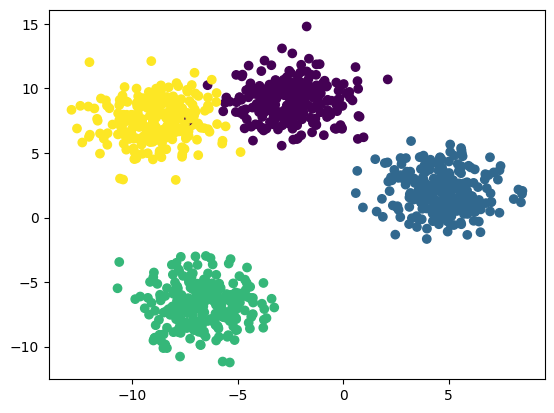

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y)

### Non-Linear Model
- using non-linear activation function: ReLU

In [6]:
class MyMulticlassModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """ Initiate multi-class classification model

        Args:
            input_features (int): num of input features to the model
            output_features (int): num of output features (classes)
            hidden_units (int): num of hidden units between layers, default: 8
        """
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
        

    def forward(self, x):
        return self.layer_stack(x)

model_1 = MyMulticlassModel(input_features=2,
                            output_features=4,
                            hidden_units=8
                           ).to(device)

# setup loss function - multiclass this time
loss_fn = nn.CrossEntropyLoss() 

# setup the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1) 

# put data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

set_seed(42)
epochs = 100

# # train model
for epoch in range(epochs):
    model_1.train() # train

    y_logits = model_1(X_train) 
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Test ###
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_1(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.54901, Acc: 24.62% | Test Loss: 1.34263, Test Acc: 26.50%
Epoch: 10 | Loss: 0.83556, Acc: 72.00% | Test Loss: 0.72577, Test Acc: 79.00%
Epoch: 20 | Loss: 0.50570, Acc: 76.12% | Test Loss: 0.42085, Test Acc: 84.50%
Epoch: 30 | Loss: 0.39071, Acc: 91.62% | Test Loss: 0.31778, Test Acc: 93.00%
Epoch: 40 | Loss: 0.32092, Acc: 94.75% | Test Loss: 0.25633, Test Acc: 95.50%
Epoch: 50 | Loss: 0.24965, Acc: 97.62% | Test Loss: 0.19486, Test Acc: 99.00%
Epoch: 60 | Loss: 0.15425, Acc: 99.12% | Test Loss: 0.11838, Test Acc: 99.00%
Epoch: 70 | Loss: 0.08863, Acc: 99.12% | Test Loss: 0.06897, Test Acc: 99.00%
Epoch: 80 | Loss: 0.06157, Acc: 99.12% | Test Loss: 0.04803, Test Acc: 99.50%
Epoch: 90 | Loss: 0.04950, Acc: 99.12% | Test Loss: 0.03823, Test Acc: 99.50%


In [7]:
# make predictions
model_1.eval()
with torch.inference_mode():
    y_logits = model_1(X_test)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

In [8]:
X_train

tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        ...,
        [-1.7366,  9.7850],
        [-6.8139, -7.1006],
        [-9.0311,  4.5007]], device='mps:0')

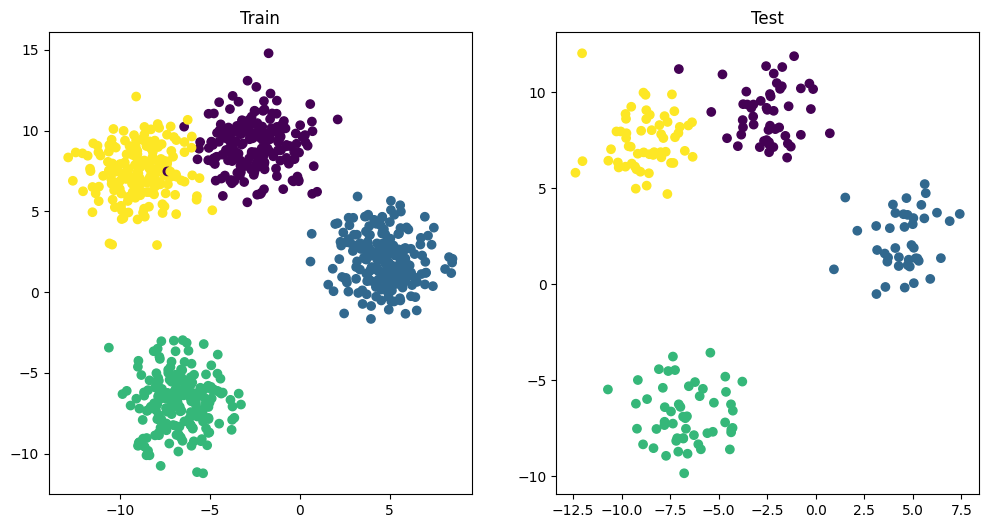

In [9]:
# plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plt.scatter(X_train.cpu()[:, 0], X_train.cpu()[:, 1], c=y_train.cpu())
plt.subplot(1, 2, 2)
plt.title("Test")
plt.scatter(X_test.cpu()[:, 0], X_test.cpu()[:, 1], c=y_preds.cpu())


### Note: Classification Metrics

#### Classification Matrix

|                  | REAL NEGATIVE | REAL POSITIVE |
|------------------|---------------|---------------|
| PREDICT <u>NEGATIVE</u> | tn - true <u>negative</u>           | fn - false <u>negative</u>          |
| PREDICT <u>POSITIVE</u> | fp - false <u>positive</u>            | tp - true <u>positive</u>        |
---

- Accuracy: ```(tp + tn) / (tp + fn + fp + fn)``` - not good option for imbalanced classes
- Precision: ```tp / (tp + fp)``` - to memorize the formula; PREcISIon == focus on PREdicted posItive SIde, check how many correct positive in positve side; high precision === less false positive
- Recall: ```tp / (tp + fn)``` - to memorize the formula; recALL == focus on ALL positive items, check how many correct positive in all positive items; high recall === less false negative
- F1-score: ```2 * (Precision * Recall) / (Precision + Recall)```

Reference: 
- http://www.kimberlyfessel.com/mathematics/data/accuracy-precision-recall/
- https://stats.stackexchange.com/questions/122225/what-is-the-best-way-to-remember-the-difference-between-sensitivity-specificity